# 1. Initialisation

## 1.1. File System

In [52]:
from google.colab import drive
#drive.mount("/content/drive", force_remount=True)
drive.mount("/content/drive")

! chmod -R 777 'drive/My Drive/Otago/A. Work in Progress/H. Roadmap/Experiment/Semantically Embedded Humanitarian Space/Model 1 Full Article'

% cd 'drive/My Drive/Otago/A. Work in Progress/H. Roadmap/Experiment/Semantically Embedded Humanitarian Space/Model 1 Full Article'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
chmod: cannot access 'drive/My Drive/Otago/A. Work in Progress/H. Roadmap/Experiment/Semantically Embedded Humanitarian Space/Model 1 Full Article': No such file or directory
[Errno 2] No such file or directory: 'drive/My Drive/Otago/A. Work in Progress/H. Roadmap/Experiment/Semantically Embedded Humanitarian Space/Model 1 Full Article'
/content/drive/My Drive/Otago/A. Work in Progress/H. Roadmap/Experiment/Semantically Embedded Humanitarian Space/Model 1 Full Article


## 1.2. Importing Libraries

In [53]:
# !pip install livelossplot
# !pip install pandas-profiling==2.7.1
# !pip uninstall -y h5py
!pip install 'h5py==2.10.0' --force-reinstall

  Using cached h5py-2.10.0-cp37-cp37m-manylinux1_x86_64.whl (2.9 MB)
  Using cached six-1.16.0-py2.py3-none-any.whl (11 kB)
  Using cached numpy-1.21.2-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (15.7 MB)
  Attempting uninstall: six
    Found existing installation: six 1.16.0
    Uninstalling six-1.16.0:
      Successfully uninstalled six-1.16.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.2
    Uninstalling numpy-1.21.2:
      Successfully uninstalled numpy-1.21.2
  Attempting uninstall: h5py
    Found existing installation: h5py 2.10.0
    Uninstalling h5py-2.10.0:
      Successfully uninstalled h5py-2.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lucid 0.3.10 requires umap-learn, which is not installed.
tensorflow 1.15.2 requires gast==0.2.2, but you have gast 0.4.0 which is incompatible.
lucid 0.3.10 requir

In [54]:
import pandas as pd
import pandas_profiling
from pandas_profiling import ProfileReport

import time
import re
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import nltk
import csv
import ast
import pickle
import itertools
import random
from scipy.spatial import distance

In [55]:
%tensorflow_version 1.x
import tensorflow as tf
from keras import Model
from keras.backend.tensorflow_backend import set_session
import sklearn.metrics
from keras.preprocessing.sequence import pad_sequences

# from sklearn import preprocessing

# from keras.preprocessing.text import one_hot
# from tensorflow.keras.preprocessing.text import Tokenizer
# from keras.utils import to_categorical
# from keras import Input
# from keras.layers import Dense, Concatenate, BatchNormalization
# from keras.layers import Flatten, Dot
# from keras.layers import LSTM, GRU, Dropout
# from keras.layers import Lambda
# from keras.layers import Activation
# from keras.layers.embeddings import Embedding
import keras.backend as K
from keras.losses import mse

In [56]:
from keras.models import load_model

In [57]:
import gensim
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from gensim.models.keyedvectors import KeyedVectors

In [58]:
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [59]:
sys.path.insert(0, './Libraries')
import preprocess

## 1.3. GPU Initialisation

In [60]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess = tf.Session(config=config)
set_session(sess)  # set this TensorFlow session as the default session for Keras

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device



## 1.4. Global Variables

In [61]:
# model_name = 'RIVEC300_'
model_name = 'RIVEC300_SMALL_'
max_word = 3500
num_ent = 100
alpha = -1.0

In [62]:
Use_Word2Vec = True

## 1.5. Model Reloading

In [63]:
def custom_loss_func(first_pos, second_pos):
    def custom_loss(y_true, y_pred):
        first_idx = K.argmax(K.abs(first_pos), axis = -1)
        second_idx = K.argmax(K.abs(second_pos), axis = -1)
        
        first_max = tf.gather(first_pos, first_idx, axis = 1)
        second_max = tf.gather(second_pos, second_idx, axis = 1)

        first_second = K.mean(mse(first_max, second_max)) * 0.1
        first_first = K.binary_crossentropy(y_true, y_pred)

        return mse(first_second, first_first)
    custom_loss.__name__ = 'custom_loss'
    return custom_loss

In [64]:
# if Use_Word2Vec:
#     word_vectors = KeyedVectors.load_word2vec_format('./Pretrained/GoogleNews-vectors-negative300.bin', binary=True)

In [65]:
# if Use_Word2Vec: w2v_ext = 'With_Word2Vec'
# else: w2v_ext = 'Without_Word2Vec'

In [66]:
modelInputFile = f'./Model/{model_name}SEmHus_Word_Embedding_Model.h5'
model = load_model(modelInputFile)

## 1.6. Tokenizers Reloading

In [67]:
with open(f'./Tokenizer/{model_name}text.pickle', 'rb') as handle:
    texts_tok = pickle.load(handle)

with open(f'./Tokenizer/{model_name}actor.pickle', 'rb') as handle:
    labActor_tok = pickle.load(handle)

with open(f'./Tokenizer/{model_name}agency.pickle', 'rb') as handle:
    labAgency_tok = pickle.load(handle)

with open(f'./Tokenizer/{model_name}sector.pickle', 'rb') as handle:
    labSector_tok = pickle.load(handle)

with open(f'./Tokenizer/{model_name}place.pickle', 'rb') as handle:
    labPlace_tok = pickle.load(handle)

with open(f'./Tokenizer/{model_name}year.pickle', 'rb') as handle:
    labYear_tok = pickle.load(handle)

with open(f'./Tokenizer/{model_name}month.pickle', 'rb') as handle:
    labMonth_tok = pickle.load(handle)

with open(f'./Tokenizer/{model_name}reason.pickle', 'rb') as handle:
    labReason_tok = pickle.load(handle)

with open(f'./Tokenizer/{model_name}goal.pickle', 'rb') as handle:
    labGoal_tok = pickle.load(handle)

# 2. Data Preparation

In [68]:
def clean_alpha(text):
    text = ' '.join([w for w in str(text).split() if w.isalpha()])
    return text

## 2.1. Input and Output

In [69]:
# normInputFile = './Inputs/SEmHus_Enriched_Normalised_Dataset.csv'
normInputFile = f'./Inputs/{model_name}SEmHus_Enriched_Normalised_Dataset_Test.csv'
normDF = pd.read_csv(normInputFile)

In [70]:
normDF = normDF.loc[(normDF['country_name'] != "['World']") & (normDF['disaster_type'] != "['Other']") & (normDF['source_type'] != "['Media']")]

In [71]:
docs = normDF['text'].tolist()
labActor = [eval(v) for v in normDF['source_name'].tolist()]
labAgency = [eval(v) for v in normDF['source_type'].tolist()]
labSector = [eval(v) for v in normDF['theme'].tolist()]
labPlace = [eval(v) for v in normDF['country_name'].tolist()]
labYear = [eval(v) for v in normDF['year_created'].tolist()]
labMonth = [eval(v) for v in normDF['month_created'].tolist()]
labReason = [eval(v) for v in normDF['disaster_type'].tolist()]
labGoal = [eval(v) for v in normDF['development_goal'].tolist()]

In [72]:
# del normDF

In [73]:
labReason_tok.classes_

array(['Cold Wave', 'Drought', 'Earthquake', 'Epidemic',
       'Extratropical Cyclone', 'Fire', 'Flash Flood', 'Flood',
       'Heat Wave', 'Insect Infestation', 'Land Slide', 'Mud Slide',
       'Other', 'Severe Local Storm', 'Snow Avalanche', 'Storm Surge',
       'Technological Disaster', 'Tropical Cyclone', 'Tsunami', 'Volcano',
       'Wild Fire'], dtype=object)

In [74]:
# lbl_sec = labSector_tok.classes_.astype('U')
# np.savetxt('./Lists/sector_list.csv', lbl_sec, delimiter=',', fmt='%s')

In [75]:
# lbl_sec = labReason_tok.classes_.astype('U')
# np.savetxt('./Lists/reason_list.csv', lbl_sec, delimiter=',', fmt='%s')

In [76]:
docs = [' '.join(str(d).lower().split()[:max_word]) for d in docs]

In [77]:
len(labActor)

5280

In [78]:
padding_len = model.layers[0].get_output_at(0).get_shape().as_list()[1]

In [79]:
padding_len

100

## 2.2. Import Dictionaries

In [80]:
list_encoded_text = f'./Dictionary/{model_name}list_encoded_text.csv'
word_embed_dict = f'./Dictionary/{model_name}word_embed_dict.csv'

# 3. Class Embedding

## 3.1. Semantic Similarity Setup

In [81]:
# from sklearn.metrics.pairwise import cosine_similarity

# # Vectors
# vec_a = [1, 2, 3, 4, 5]
# vec_b = [1, 3, 5, 7, 9]

# # Dot and norm
# dot = sum(a*b for a, b in zip(vec_a, vec_b))
# norm_a = sum(a*a for a in vec_a) ** 0.5
# norm_b = sum(b*b for b in vec_b) ** 0.5

# # Cosine similarity
# cos_sim = dot / (norm_a*norm_b)

# # Results
# print('My version:', cos_sim)
# print('Scikit-Learn:', cosine_similarity([vec_a], [vec_b]))

In [82]:
def cosine(vec1, vec2):
    vec1 = np.array(vec1).tolist()
    vec2 = np.array(vec2).tolist()
    dot = sum(a*b for a, b in zip(vec1, vec2))
    norm_a = sum(a*a for a in vec1) ** 0.5
    norm_b = sum(b*b for b in vec2) ** 0.5
    cos_sim = dot / (norm_a*norm_b)
    return cos_sim

In [83]:
# num_word = 20

In [84]:
agency_weight = model.get_layer('outAgency').get_weights()[0]
agency_transpose = np.asarray(np.transpose(agency_weight))
agency_embed = {w: agency_transpose[idx] for idx, w in enumerate(labAgency_tok.classes_)}

actor_weight = model.get_layer('outActor').get_weights()[0]
actor_transpose = np.asarray(np.transpose(actor_weight))
actor_embed = {w: actor_transpose[idx] for idx, w in enumerate(labActor_tok.classes_)}

goal_weight = model.get_layer('outGoal').get_weights()[0]
goal_transpose = np.asarray(np.transpose(goal_weight))
goal_embed = {w: goal_transpose[idx] for idx, w in enumerate(labGoal_tok.classes_)}

sector_weight = model.get_layer('outSector').get_weights()[0]
sector_transpose = np.asarray(np.transpose(sector_weight))
sector_embed = {w: sector_transpose[idx] for idx, w in enumerate(labSector_tok.classes_)}

place_weight = model.get_layer('outPlace').get_weights()[0]
place_transpose = np.asarray(np.transpose(place_weight))
place_embed = {w: place_transpose[idx] for idx, w in enumerate(labPlace_tok.classes_)}

year_weight = model.get_layer('outYear').get_weights()[0]
year_transpose = np.asarray(np.transpose(year_weight))
year_embed = {w: year_transpose[idx] for idx, w in enumerate(labYear_tok.classes_)}

month_weight = model.get_layer('outMonth').get_weights()[0]
month_transpose = np.asarray(np.transpose(month_weight))
month_embed = {w: month_transpose[idx] for idx, w in enumerate(labMonth_tok.classes_)}

reason_weight = model.get_layer('outReason').get_weights()[0]
reason_transpose = np.asarray(np.transpose(reason_weight))
reason_embed = {w: reason_transpose[idx] for idx, w in enumerate(labReason_tok.classes_)}

## 3.2. Vector Space Export

In [85]:
def normalize(word_vec):
    norm=np.linalg.norm(word_vec)
    if norm == 0:
       return word_vec
    return word_vec/norm

In [86]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)

In [87]:
cols = ['Class', 'Entity', 'Vector', 'X', 'Y']
rows = []

ent = []
nam = []
vec = []

for key, value in agency_embed.items():
    ent.append('Agency')
    nam.append(key)
    normed = normalize(list(value))
    vec.append(normed)

for key, value in actor_embed.items():
    ent.append('Actor')
    nam.append(key)
    normed = normalize(list(value))
    vec.append(normed)

for key, value in goal_embed.items():
    ent.append('Goal')
    nam.append(key)
    normed = normalize(list(value))
    vec.append(normed)

for key, value in sector_embed.items():
    ent.append('Sector')
    nam.append(key)
    normed = normalize(list(value))
    vec.append(normed)

for key, value in place_embed.items():
    ent.append('Place')
    nam.append(key)
    normed = normalize(list(value))
    vec.append(normed)

for key, value in year_embed.items():
    ent.append('Year')
    nam.append(key)
    normed = normalize(list(value))
    vec.append(normed)

for key, value in month_embed.items():
    ent.append('Month')
    nam.append(key)
    normed = normalize(list(value))
    vec.append(normed)

for key, value in reason_embed.items():
    ent.append('Reason')
    nam.append(key)
    normed = normalize(list(value))
    vec.append(normed)

reduced_vector = tsne.fit_transform(vec)
X_dim = reduced_vector[:,0]
Y_dim = reduced_vector[:,1]

In [88]:
rows = np.array([ent, nam, vec, X_dim, Y_dim])

rows_t = rows.T 

class_df = pd.DataFrame(data=rows_t, columns = cols)
class_df.to_csv(f'./Outputs/{model_name}Humanitarian_Class_Vector_Space.csv')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


In [89]:
# class_data = class_df.values.tolist()

## 3.3. Entity Distance Export

In [90]:
file_name = f'./Outputs/{model_name}Humanitarian_Class_Distance_Space.csv'

if os.path.isfile(file_name):
    dist_df = pd.read_csv(file_name)
else:
    cols = ['Source_Class', 'Source_Entity', 'Target_Class', 'Target_Entity', 'Distance']
    rows = []

    for sidx, source in class_df.iterrows():
        for tidx, target in class_df.iterrows():

            if (source['Class'] == target['Class']) and (source['Entity'] == target['Entity']): continue
            
            # dist = distance.euclidean(source['Vector'], target['Vector'])
            dist = distance.cosine(source['Vector'], target['Vector'])
            rows.append([source['Class'], source['Entity'], target['Class'], target['Entity'], dist])

    dist_df = pd.DataFrame(data=rows, columns = cols)
    dist_df.to_csv(file_name)

In [91]:
def merge(list1, list2):
    merged_list = [(list1[i], list2[i]) for i in range(0, len(list1))]
    return merged_list

In [92]:
def nearest_class(first, second, third, near):

    class_list = dist_df[(dist_df['Source_Class'] == first) & (dist_df['Target_Class'] == second) & (dist_df['Target_Entity'] == third) ]

    dist = []

    # nam = []
    # dis = []

    for idx, row in class_list.iterrows():
        d = row[5]
        # d = row[4]
        if d > 0:
            #dist.append((np.linalg.norm(vec1 - vec2), word))
            dist.append((round(d, 4), row['Source_Entity']))
            # nam.append(row['Source_Entity'])
            # dis.append(d)
    
    # dis = normalize(dis)
    # dist = merge(dis, nam)
    
    dist.sort()
    dist = dist[:near]

    return dist

In [93]:
def find_stat(cls):
    if cls == '*':
        temp_df = dist_df[(dist_df['Distance'] > 0)]
    else:
        temp_df = dist_df[(dist_df['Source_Class'] == cls) & (dist_df['Distance'] > 0)]

    dist_lst = temp_df['Distance'].values

    sd = np.std(dist_lst)
    me = np.mean(dist_lst)
    mx = np.max(dist_lst)
    mn = np.min(dist_lst)
    cs = (mx - mn) / sd

    return sd, me, mx, mn, cs

In [94]:
def find_rank(cls, val, alpha):
    
    stat = find_stat(cls)
    
    stdev = stat[0]
    mean = stat[1]
    # measure = mean - (alpha * stdev)
    measure = (val - mean) / stdev

    # if alpha < measure: rank = 'Accepted'
    # if alpha >= measure: rank = 'Rejected'

    if alpha >= measure: rank = 'Accepted'
    if alpha < measure: rank = 'Rejected'

    return rank

In [95]:
# class_df = dist_df[(dist_df['Source_Class'] == 'Place') & (dist_df['Distance'] > 0)]
# # class_df = dist_df[(dist_df['Distance'] > 0)]

# dist_lst = class_df['Distance'].values

cls = 'Year'
stat = find_stat(cls)

print('Standard Deviation:', round(stat[0], 6))
print('Mean Distance:', round(stat[1], 6))
print('Maximum Distance:', round(stat[2], 6))
print('Minimum Distance :', round(stat[3], 6))
print('Number of CS :', round(stat[4], 6))

Standard Deviation: 0.081697
Mean Distance: 0.980457
Maximum Distance: 1.317971
Minimum Distance : 0.477384
Number of CS : 10.28912


# 4. Result Validation

## 4.1. Histogram

In [96]:
alpha = -1.0

In [104]:
var1, var2 = 'Reason', 'Place'

if var2 == 'Agency': rand_class = labAgency_tok.classes_[random.randint(0, len(labAgency_tok.classes_)-1)]
if var2 == 'Actor': rand_class = labActor_tok.classes_[random.randint(0, len(labActor_tok.classes_)-1)]
if var2 == 'Goal': rand_class = labGoal_tok.classes_[random.randint(0, len(labGoal_tok.classes_)-1)]
if var2 == 'Sector': rand_class = labSector_tok.classes_[random.randint(0, len(labSector_tok.classes_)-1)]
if var2 == 'Place': rand_class = labPlace_tok.classes_[random.randint(0, len(labPlace_tok.classes_)-1)]
if var2 == 'Year': rand_class = labYear_tok.classes_[random.randint(0, len(labYear_tok.classes_)-1)]
if var2 == 'Month': rand_class = labMonth_tok.classes_[random.randint(0, len(labMonth_tok.classes_)-1)]
if var2 == 'Reason': rand_class = labReason_tok.classes_[random.randint(0, len(labReason_tok.classes_)-1)]

rand_class = 'Sudan'

ents = nearest_class(var1, var2, rand_class, num_ent)

accepted_list = ''
rejected_list = ''

acc_ent = []
rej_ent = []

en, dt, sd, me = [], [], [], []

# cls = '*'
cls = var1

alpha = 0.0

stat = find_stat(cls)

for ent in ents:
    rank = find_rank(cls, ent[0], alpha)
    if rank == 'Accepted':
        en.append(ent[1])
        dt.append(ent[0])
        sd.append(stat[0])
        me.append(stat[1])
    d = round(ent[0], 4)
    z = round((ent[0] - stat[1]) / stat[0], 4)
    if rank == 'Accepted':
        accepted_list += f'{ent[1]} [Distance={d}, Z-Score={z}] -- [{rank}];\n'
        acc_ent.append(ent[1])
    else:
        rejected_list += f'{ent[1]} [Distance={d}, Z-Score={z}] -- [{rank}];\n'
        rej_ent.append(ent[1])
    # nearest_list += f'{ent[1]} ({z}); '
    # nearest_list += f'{ent[1]} ({d}); \n'

# nearest_title = f'Nearest {var1}(s) to {var2} [{rand_class}] are {len(en)}:\n'
nearest_title = f'Nearest {var1}(s) to {var2} [{rand_class}] are {len(en)}:\n'

print(nearest_title)
print('Accepted Results:')
print(accepted_list)
print('Rejected Results:')
print(rejected_list)

Nearest Reason(s) to Place [Sudan] are 7:

Accepted Results:
Flash Flood [Distance=0.7929, Z-Score=-2.3525] -- [Accepted];
Flood [Distance=0.8101, Z-Score=-2.1357] -- [Accepted];
Insect Infestation [Distance=0.8962, Z-Score=-1.0502] -- [Accepted];
Epidemic [Distance=0.9174, Z-Score=-0.7829] -- [Accepted];
Wild Fire [Distance=0.9566, Z-Score=-0.2887] -- [Accepted];
Technological Disaster [Distance=0.9619, Z-Score=-0.2219] -- [Accepted];
Drought [Distance=0.9708, Z-Score=-0.1097] -- [Accepted];

Rejected Results:
Other [Distance=0.98, Z-Score=0.0063] -- [Rejected];
Earthquake [Distance=0.9901, Z-Score=0.1336] -- [Rejected];
Storm Surge [Distance=0.9911, Z-Score=0.1462] -- [Rejected];
Fire [Distance=1.0059, Z-Score=0.3328] -- [Rejected];
Extratropical Cyclone [Distance=1.0074, Z-Score=0.3517] -- [Rejected];
Tsunami [Distance=1.0232, Z-Score=0.5509] -- [Rejected];
Tropical Cyclone [Distance=1.0292, Z-Score=0.6266] -- [Rejected];
Severe Local Storm [Distance=1.0324, Z-Score=0.6669] -- [Reje

In [98]:
%matplotlib inline

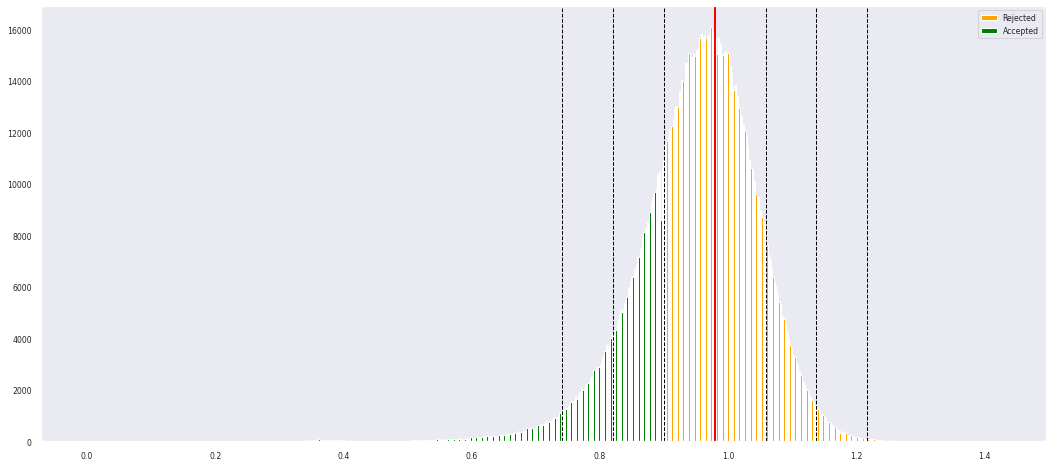

In [99]:
plot_df = dist_df
# plot_df = dist_df[(dist_df['Source_Class'] == cls)]

plt.figure()

binval = 750

all = plot_df

if len(dt) == 0:
    plot_df.Distance.hist(color='orange', bins=binval, alpha=1.0, figsize=(18, 8), label='Rejected')
else:
    neg = plot_df[(plot_df['Distance'] > max(dt))]
    pos = plot_df[(plot_df['Distance'] <= max(dt))]

    max_all = all['Distance'].max()

    neg.Distance.hist(grid=False, color='orange', bins=binval, alpha=1.0, figsize=(18, 8), range=[0, max_all], label='Rejected')
    pos.Distance.hist(grid=False, color='green', bins=binval, alpha=1.0, figsize=(18, 8), range=[0, max_all], label='Accepted')

for i in range(4):
    plt.axvline(stat[1]+(stat[0]*i), linewidth=1, color='black', linestyle='dashed')
    plt.axvline(stat[1]-(stat[0]*i), linewidth=1, color='black', linestyle='dashed')

plt.axvline(stat[1], linewidth=2, color='red')

plt.legend()

# plot_df.Distance.hist(color='orange', bins=125, alpha=1.0, figsize=(18, 8))
# plot_df.Distance.hist(by=plot_df.Source_Class, color='orange', bins=125, alpha=1.0, figsize=(18, 12))
# plot_df.groupby('Source_Class').Distance.hist(bins=125, alpha=0.8, figsize=(18, 12))

In [100]:
import seaborn as sns
import matplotlib.pyplot as plt

In [101]:
def extra_lines(plot, cls):

    line = find_stat(cls)

    plot.axvline(line[1], linewidth=1.0, color='red')
    plot.text(line[1]+0.01, 8, f's.d. = {round(line[0], 2)} | mean = {round(line[1], 2)}', rotation=270, verticalalignment='bottom')

    plot.axvline(line[2], linewidth=0.5, color='blue')
    plot.text(line[2]+0.01, 2, f'max = {round(line[2], 2)}', rotation=270, verticalalignment='bottom')

    plot.axvline(line[3], linewidth=0.5, color='blue')
    plot.text(line[3]+0.01, 2, f'min = {round(line[3], 2)}', rotation=270, verticalalignment='bottom')

    for i in range(1, 4):
        w = line[1]+(line[0]*i)
        plot.axvline(w, linewidth=0.5, color='black', linestyle='dashed')
        plot.text(w+0.01, 2, f's.d. ({i}) = {round(w, 2)}', rotation=270, verticalalignment='bottom')

    for i in range(1, 4):
        w = line[1]-(line[0]*i)
        plot.axvline(w, linewidth=0.5, color='black', linestyle='dashed')
        plot.text(w+0.01, 2, f's.d. ({i}) = {round(w, 2)}', rotation=270, verticalalignment='bottom')

    
    
    plot.legend()

    return None

KeyboardInterrupt: ignored

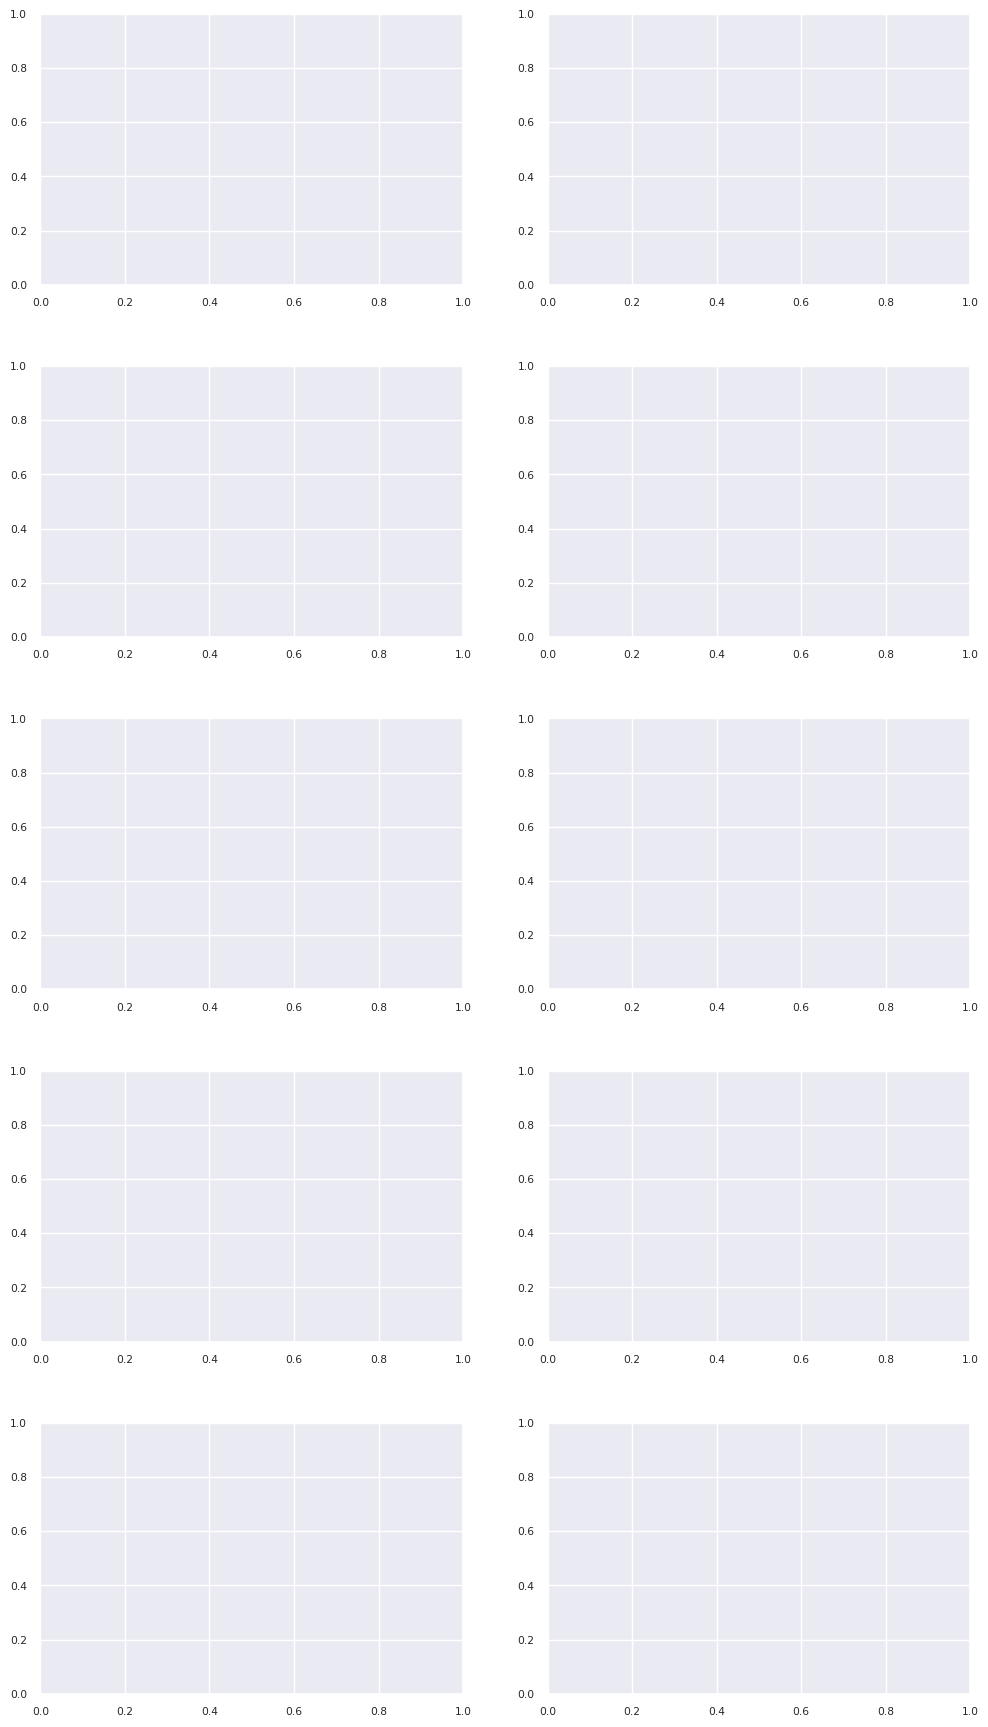

In [102]:
# sns.set()

# data

data_all = dist_df['Distance'].rename('All')
data_agency = dist_df[(dist_df['Source_Class'] == 'Agency')]['Distance'].rename('Agency')
data_goal = dist_df[(dist_df['Source_Class'] == 'Goal')]['Distance'].rename('Goal')

data_actor = dist_df[(dist_df['Source_Class'] == 'Actor')]['Distance'].rename('Actor')
data_sector = dist_df[(dist_df['Source_Class'] == 'Sector')]['Distance'].rename('Sector')
data_reason = dist_df[(dist_df['Source_Class'] == 'Reason')]['Distance'].rename('Reason')

data_place = dist_df[(dist_df['Source_Class'] == 'Place')]['Distance'].rename('Place')
data_year = dist_df[(dist_df['Source_Class'] == 'Year')]['Distance'].rename('Year')
data_month = dist_df[(dist_df['Source_Class'] == 'Month')]['Distance'].rename('Month')

# sd, me, mx, mn, cs

line_all = find_stat('*')
line_agency = find_stat('Agency')
line_goal = find_stat('Goal')
line_actor = find_stat('Actor')
line_sector = find_stat('Sector')
line_reason = find_stat('Reason')
line_place = find_stat('Place')
line_year = find_stat('Year')
line_month = find_stat('Month')


# plot

sns.set(font_scale=0.7)

fig, axes = plt.subplots(5, 2, figsize=(12, 12), sharey=False, dpi=100)  
plt.subplots_adjust(bottom=0.2, top=1.6, hspace=0.3)

plot_all = sns.histplot(data_all, color="orange", ax=axes[0, 0], kde = True, label='All')
plot_agency = sns.histplot(data_agency, color="gray", ax=axes[0, 1], kde = True, label='Agency')
plot_goal = sns.histplot(data_goal, color="brown", ax=axes[1, 0], kde = True, label='Goal')

plot_actor = sns.histplot(data_actor, color="dodgerblue", ax=axes[1, 1], kde = True, label='Actor')
plot_sector = sns.histplot(data_sector, color="deeppink", ax=axes[2, 0], kde = True, label='Sector')
plot_reason = sns.histplot(data_reason, color="olive", ax=axes[2, 1], kde = True, label='Reason')

plot_place = sns.histplot(data_place, color="blue", ax=axes[3, 0], kde = True, label='Place')
plot_year = sns.histplot(data_year, color="green", ax=axes[3, 1], kde = True, label='Year')
plot_month = sns.histplot(data_month, color="gold", ax=axes[4, 0], kde = True, label='Month')

# extra lines

extra_lines(plot_all, '*')
extra_lines(plot_agency, 'Agency')
extra_lines(plot_goal, 'Goal')
extra_lines(plot_actor, 'Actor')
extra_lines(plot_sector, 'Sector')
extra_lines(plot_reason, 'Reason')
extra_lines(plot_place, 'Place')
extra_lines(plot_year, 'Year')
extra_lines(plot_month, 'Month')